In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

np.random.seed(42)

### 1. Create data sample

In [3]:
days = []
for d in range(1, 6):
    n = np.random.randint(800, 1200)  # random number of records per day
    if d == 3: # Last day has fewer records
        n = np.random.randint(200, 400)
    elif d == 5: # First day has more records
        n = np.random.randint(4000, 10000)
    day = {
        'order_id': range(1000*(d-1)+1, 1000*(d-1)+n+1),
        'customer_id': np.random.randint(100, 200, n),
        'product_id': np.random.randint(1000, 1100, n),
        'order_date': f'2023-01-0{d}',
        'quantity': np.random.randint(1, 10, n),
        'price': np.random.uniform(10, 1000, n),
        'sales_rep': np.random.choice(['Alice', 'Bob', 'Charlie', 'David'], n),
        'use_voucher': np.random.choice([1, np.nan], n)
    }
    day['total_amount'] = day['quantity'] * day['price']
    days.append(day)

orders_df = pd.concat([pd.DataFrame(day) for day in days], ignore_index=True)
orders_df

,order_id,customer_id,product_id,order_date,quantity,price,sales_rep,use_voucher,total_amount
0,1,151,1079,2023-01-01,5,427.035573,Alice,NaN,2135.177864
1,2,192,1094,2023-01-01,7,639.815591,Bob,1.0,4478.709137
2,3,114,1074,2023-01-01,2,787.795102,Bob,NaN,1575.590204
3,4,171,1015,2023-01-01,4,127.152829,David,1.0,508.611316
4,5,160,1007,2023-01-01,2,415.805841,Alice,1.0,831.611682
...,...,...,...,...,...,...,...,...,...
10074,10742,159,1072,2023-01-05,2,107.934246,David,NaN,215.868492
10075,10743,130,1049,2023-01-05,3,800.593337,Alice,1.0,2401.780012
10076,10744,157,1044,2023-01-05,4,674.077429,David,1.0,2696.309715
10077,10745,196,1086,2023-01-05,9,321.573535,David,1.0,2894.161816


In [4]:
num_nulls = 700  # create null values 
row_indices = np.random.choice(orders_df.index, num_nulls, replace=False)
col_names = np.random.choice([col for col in orders_df.columns if col != 'use_voucher'], num_nulls)

for r, c in zip(row_indices, col_names):
    orders_df.loc[r, c] = np.nan

### 1. Completeness dimension

In [5]:
# Group by each column and calculate null ratio, null count, and row count for each day
result = {}
for col in orders_df.columns:
    # Group by order_date and calculate stats for the current column
    stats = orders_df.groupby('order_date')[col].apply(
        lambda x: pd.Series({
            'null_count': x.isnull().sum(),
            'row_count': x.shape[0],
            'null_ratio': x.isnull().mean()
        })
    )
    result[col] = stats

# Combine results into a single DataFrame for easier viewing
summary_df = pd.concat(result, axis=1)
completeness_df = summary_df.stack(level=0).reset_index()
completeness_df.columns = ['order_date', 'metric_name', 'column_name', 'metric_value']
completeness_df

,order_date,metric_name,column_name,metric_value
0,2023-01-01,null_count,order_id,6.000000
1,2023-01-01,null_count,customer_id,5.000000
2,2023-01-01,null_count,product_id,9.000000
3,2023-01-01,null_count,order_date,0.000000
4,2023-01-01,null_count,quantity,13.000000
...,...,...,...,...
130,2023-01-05,null_ratio,quantity,0.008835
131,2023-01-05,null_ratio,price,0.009434
132,2023-01-05,null_ratio,sales_rep,0.007637
133,2023-01-05,null_ratio,use_voucher,0.490416


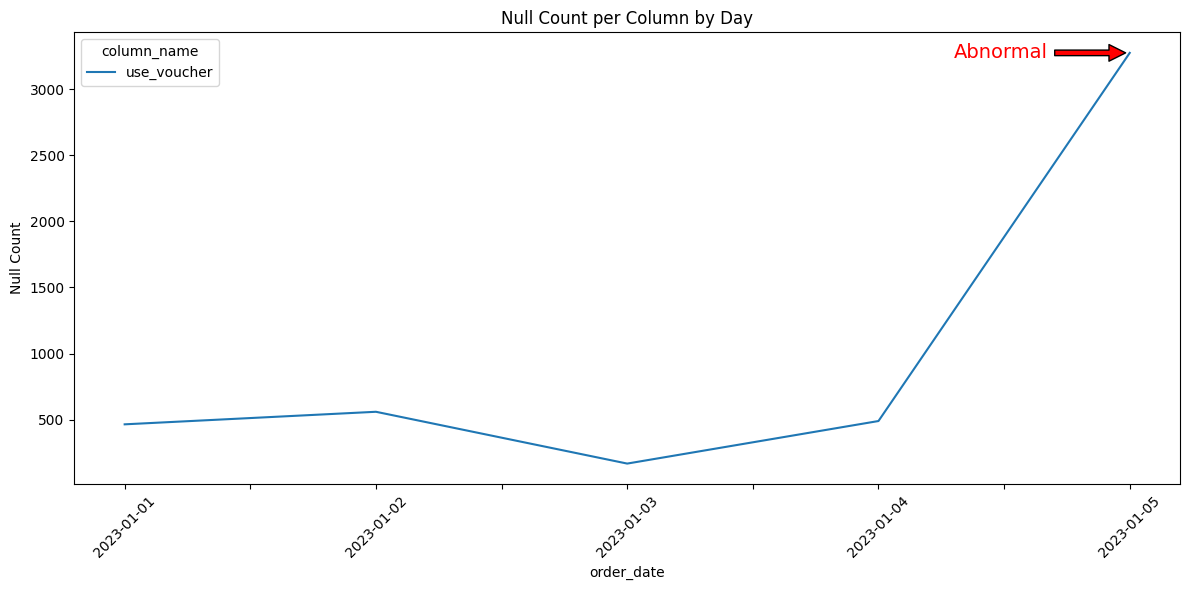

In [6]:
# Filter for null_count metrics
null_count_df = completeness_df[(completeness_df['metric_name'] == 'null_count') & (completeness_df['column_name'] == 'use_voucher')]

# Pivot for easier plotting
pivot_df = null_count_df.pivot(index='order_date', columns='column_name', values='metric_value')

# Plot
pivot_df.plot(kind='line', figsize=(12, 6))
plt.ylabel('Null Count')
plt.title('Null Count per Column by Day')
plt.xticks(rotation=45)
plt.tight_layout()

# Annotate the abnormal point using the correct x coordinate index
x_idx = pivot_df.index.get_loc('2023-01-05')
plt.annotate('Abnormal',
             xy=(x_idx, pivot_df.loc['2023-01-05', 'use_voucher']),
             xytext=(x_idx-0.7, pivot_df.loc['2023-01-05', 'use_voucher']),
             arrowprops=dict(facecolor='red', shrink=0.05),
             color='red', fontsize=14, va='center', ha='left')
plt.show()

**Theory (Completeness Dimension):**

Completeness refers to the extent to which all required data is present in a dataset. In the context of data quality, completeness measures the proportion of missing values for each column or record. High completeness means that most or all expected data is available, while low completeness indicates many missing or null values. Assessing completeness helps identify gaps in data collection, integration, or processing, and is essential for ensuring reliable analysis and decision-making.

### 2. Validty dimension

In [7]:
orders_df_invalid = orders_df.copy()

# Get indices of last day
last_day = '2023-01-05'
last_day_indices = orders_df_invalid[orders_df_invalid['order_date'] == last_day].index

# Randomly select 50 indices from last day
invalid_indices = np.random.choice(last_day_indices, 50, replace=False)

# Set 'price' to a string value for these indices
orders_df_invalid.loc[invalid_indices, 'price'] = 'invalid_price'

In [8]:
# Create a mask for invalid price values (not float or int)
invalid_price_mask = ~orders_df_invalid['price'].apply(lambda x: isinstance(x, (float, int)))

# Group by order_date and count invalid price records for all days
invalid_price_count = orders_df_invalid[invalid_price_mask].groupby('order_date').size()

invalid_price_count

order_date
2023-01-05    50
dtype: int64

The theoretical value for `price` should be a number, as shown in the results above. Any non-numeric value (such as a string like `'invalid_price'`) is considered invalid for the `price` column.

### 3. Consistance dimension

In [12]:
# Copy the last day's data and update 'order_date' to '2023-01-06'
new_day_df = pd.DataFrame(day).sample(50).reset_index(drop=True).copy()
new_day_df['order_date'] = '2023-01-06'

# Optionally, rename columns if needed (example: change 'sales_rep' to 'rep_name')
new_day_df = new_day_df.rename(columns={'sales_rep': 'rep_name'})

new_day_df.head()

,order_id,customer_id,product_id,order_date,quantity,price,rep_name,use_voucher,total_amount
0,7015,190,1093,2023-01-06,2,16.768046,David,1.0,33.536092
1,4836,162,1061,2023-01-06,3,19.758262,Charlie,NaN,59.274785
2,7299,141,1071,2023-01-06,9,696.987179,Bob,1.0,6272.884607
3,9749,194,1088,2023-01-06,2,115.645319,Alice,NaN,231.290638
4,7349,149,1090,2023-01-06,8,466.326542,Alice,NaN,3730.612339


Theory:
    To check consistency, we compare the columns of `orders_df` and `new_day_df`.

    If columns differ, it may indicate schema drift or inconsistency in data sources.
    
    For example, `orders_df` uses 'sales_rep' while `new_day_df` uses 'rep_name'.

In [13]:
orders_columns = set(orders_df.columns)
new_day_columns = set(new_day_df.columns)

print("Columns in orders_df:", orders_columns)
print("Columns in new_day_df:", new_day_columns)
print("Columns only in orders_df:", orders_columns - new_day_columns)
print("Columns only in new_day_df:", new_day_columns - orders_columns)

Columns in orders_df: {'quantity', 'order_id', 'product_id', 'customer_id', 'total_amount', 'use_voucher', 'sales_rep', 'price', 'order_date'}
Columns in new_day_df: {'quantity', 'order_id', 'product_id', 'customer_id', 'rep_name', 'total_amount', 'use_voucher', 'price', 'order_date'}
Columns only in orders_df: {'sales_rep'}
Columns only in new_day_df: {'rep_name'}


### 4. Uniqueness dimension

In [15]:
# Copy a sample of orders and fake data so that one order_id maps to two customer_id values
orders_df_uniqueness = orders_df.query("order_date == '2023-01-01'").sample(10).copy()

# Select a random order_id to duplicate
order_id_to_duplicate = orders_df_uniqueness['order_id'].dropna().sample(1).values[0]

# Find the row(s) with this order_id
rows_to_duplicate = orders_df_uniqueness[orders_df_uniqueness['order_id'] == order_id_to_duplicate]

# Create a duplicate row with a different customer_id
fake_row = rows_to_duplicate.copy()
fake_row['customer_id'] = np.random.choice(orders_df_uniqueness['customer_id'].dropna().unique())

# Append the fake row to the dataframe
orders_df_uniqueness = pd.concat([orders_df_uniqueness, fake_row], ignore_index=True)

# Show the duplicated order_id rows
orders_df_uniqueness[orders_df_uniqueness['order_id'] == order_id_to_duplicate]

,order_id,customer_id,product_id,order_date,quantity,price,sales_rep,use_voucher,total_amount
9,310.0,135.0,1042.0,2023-01-01,6.0,595.780191,David,NaN,3574.681144
10,310.0,175.0,1042.0,2023-01-01,6.0,595.780191,David,NaN,3574.681144


Uniqueness means that certain fields in a dataset, like order IDs, should not have duplicate values. This is important for keeping data accurate and reliable. If there are duplicates, it can cause problems, such as counting the same order more than once or mixing up customer information. In the example above, we created a duplicate order_id with different customer_id values to show what happens when uniqueness is violated. It's important to check for and fix these issues to maintain good data quality.

### 5. Timeliness dimension

In [21]:
# Assume the ML model is trained in 2025
ml_train_year = 2025

# Get the years present in order_date of orders_df
order_years = pd.to_datetime(orders_df['order_date'], errors='coerce').dt.year.dropna().unique()

# Assess time frame: if all years in orders_df < training year, data is outdated
is_outdated = all(order_year < ml_train_year for order_year in order_years)

print("Years in data:", order_years)
print("ML training year:", ml_train_year)
print("Data is outdated:", is_outdated)

Years in data: [2023.]
ML training year: 2025
Data is outdated: True


**Explanation (Timeliness Dimension Result):**

The result shows that all data in `orders_df` is from the year 2023, while the machine learning model is trained in 2025 (`ml_train_year = 2025`). This means the dataset is outdated and does not reflect the most recent business situation. Using old data may lead to inaccurate predictions or decisions because it does not capture current trends or changes. Therefore, it is important to regularly update the dataset to ensure it remains relevant and useful for analysis or modeling.